In [1154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#scikit-learn other models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score


In [1155]:
training_data = pd.read_csv('titanic_train.csv')
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1156]:
training_data.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [1157]:
#are there any null values in the dataset?
#training_data.isnull().sum()
#I can get the first letter of the missing cabin values using the fare column
def gert_first_char(cabin):
    if cabin is np.nan:
        return 'U'
    else:
        return cabin[0]
    


In [1158]:
# This section is for feature engineering


# We will create a new feature called "FamilySize" which is the sum of "SibSp" and "Parch" plus 1 (for the individual themselves)
def get_family_size(SibSp, Parch):
    return SibSp + Parch + 1

#this section is to figure out if a cabin is present or not
# We will create a new feature called "Cabin" which is 1 if the cabin is present and 0 if not
def get_cabin(Cabin):
    if pd.isna(Cabin):
        return 0
    else:
        return 1
    
#this is for the tittle of the passenger
# We will create a new feature called "Tittle" which is 0 for Mr., 1 for Mrs., 2 for Miss., 3 for Master. and 4 for other titles
def get_tittle(Name):
    if 'Mr.' in Name or 'Mrs.' in Name or 'Miss.' in Name or 'Master.' in Name:
        return 0  # Not special
    else:
        return 1  # Special

#impute the age using the mean of the age of the passengers in the same class
def fill_age(Age, Pclass):
    if pd.isna(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

    
training_data['Age'] = training_data.apply(lambda x: fill_age(x['Age'], x['Pclass']), axis=1)
training_data['Tittle'] = training_data['Name'].apply(get_tittle)
training_data['FamilySize'] = training_data.apply(lambda x: get_family_size(x['SibSp'], x['Parch']), axis=1)
training_data['Cabin'] = training_data['Cabin'].apply(gert_first_char)
get_dummies_cabin = pd.get_dummies(training_data['Cabin'], dtype=float, drop_first=True)
training_data = pd.concat([training_data, get_dummies_cabin], axis=1)
get_dummies_emb = pd.get_dummies(training_data['Embarked'], dtype=float, drop_first=True)
training_data = pd.concat([training_data, get_dummies_emb], axis=1) 
get_dummies = pd.get_dummies(training_data['Sex'], dtype=float, drop_first=True)
training_data = pd.concat([training_data, get_dummies], axis=1)
    
#training_data['Cabin'] = training_data['Cabin'].apply(get_cabin)

<Axes: xlabel='TicketLength', ylabel='Age'>

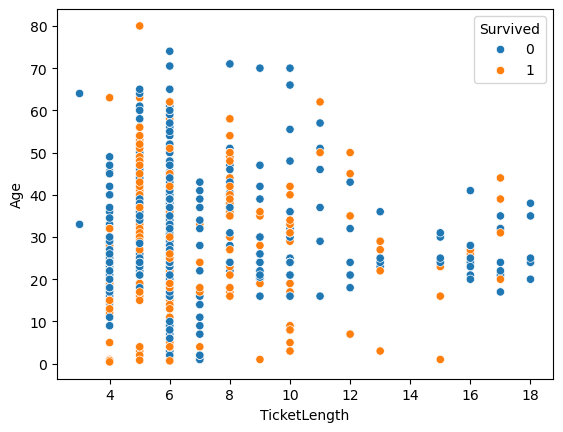

In [1159]:
training_data['Tittle'].value_counts()
#sns.countplot(x='Tittle', data=training_data, hue='Survived')

#I want to see the relationship between ticket lenght and survival
training_data['TicketLength'] = training_data['Ticket'].apply(lambda x: len(x))
#sns.countplot(x='TicketLength', data=training_data, hue='Survived')
#sns.countplot(x='Q', data=training_data, hue='Survived')
#sns.countplot(x='S', data=training_data, hue='Survived')
#i just want to make a scater plot to represent the data
sns.scatterplot(x='TicketLength', y='Age', data=training_data, hue='Survived')

In [1160]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,D,E,F,G,T,U,Q,S,male,TicketLength
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,9
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,16
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,6


In [1161]:
#check for null values again
training_data.isnull().sum()
#DROP ANY NULL VALUES
training_data = training_data.dropna()

In [1162]:
#okay let's drop the columns we don't need
training_data = training_data.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin', 'SibSp', 'Parch','Sex', 'Fare','TicketLength','T'], axis=1)

In [1163]:
X = training_data.drop('Survived', axis=1)
y = training_data['Survived']
X.head(5)

,Pclass,Age,Tittle,FamilySize,B,C,D,E,F,G,U,Q,S,male
0,3,22.0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1,38.0,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,26.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,35.0,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,35.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [1077]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
#I want to improve the Random forest using GridSearchCV
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 300, 500],         # Number of trees
    'max_depth': [10, 20, 30],               # Maximum depth of trees
    'min_samples_split': [2, 5, 10],         # Min samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # Min samples per leaf
    'max_features': ['sqrt', 'log2'],        # Number of features considered at each split
    'bootstrap': [True, False]               # Use bootstrap sampling
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit to the dataset (X_train, y_train)
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf = grid_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8651685393258427


In [1076]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# I am going to write a function that will take in a model and the training data and return the accuracy of the model
def get_accuracy(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    return accuracy

#then test each of these models to see which one is best
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest':  RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=True),
    'Decision Tree': DecisionTreeClassifier(),
    'SVC': SVC(),
    'KNN': KNeighborsClassifier(n_neighbors= 5),
    'Naive Bayes': GaussianNB()
}
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions)
    results[model_name] = {
        'F1 Score': f1
    }

for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions)
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    results[model_name] = {
        'F1 Score': f1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='F1 Score', ascending=False)
print(results_df)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

                     F1 Score  Accuracy  Precision    Recall
Random Forest        0.794118  0.842697   0.830769  0.760563
Logistic Regression  0.763359  0.825843   0.833333  0.704225
KNN                  0.704000  0.792135   0.814815  0.619718
Decision Tree        0.701493  0.775281   0.746032  0.661972
Naive Bayes          0.559322  0.707865   0.702128  0.464789
SVC                  0.255814  0.640449   0.733333  0.154930


In [1173]:
#using the decision tree model to predict the test data
#{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
#rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', bootstrap=True)
rf = LogisticRegression()
rf.fit(X, y)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [1174]:
test_data = pd.read_csv('titanic_test.csv')
test_id = test_data['PassengerId']
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [1175]:
#need to apply same functions to the test data
test_data['Age'] = test_data.apply(lambda x: fill_age(x['Age'], x['Pclass']), axis=1)
test_data['Tittle'] = test_data['Name'].apply(get_tittle)
test_data['FamilySize'] = test_data.apply(lambda x: get_family_size(x['SibSp'], x['Parch']), axis=1)
test_data['Cabin'] = test_data['Cabin'].apply(gert_first_char)
get_dummies_cabin = pd.get_dummies(test_data['Cabin'], dtype=float, drop_first=True)
test_data = pd.concat([test_data, get_dummies_cabin], axis=1)
get_dummies_emb = pd.get_dummies(test_data['Embarked'], dtype=float, drop_first=True)
test_data = pd.concat([test_data, get_dummies_emb], axis=1)
get_dummies = pd.get_dummies(test_data['Sex'], dtype=float, drop_first=True)
test_data = pd.concat([test_data, get_dummies], axis=1)
test_data['TicketLength'] = test_data['Ticket'].apply(lambda x: len(x))

In [1176]:
#drop the columns we don't need
test_data = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin', 'SibSp', 'Parch','Sex', 'Fare', 'TicketLength'], axis=1)
len(X.columns)==len(test_data.columns)

True

In [1177]:
X.head(5)

,Pclass,Age,Tittle,FamilySize,B,C,D,E,F,G,U,Q,S,male
0,3,22.0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1,38.0,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,26.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,35.0,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,35.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [1178]:
rf.predict(test_data)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [1179]:
# Ensure test_id is correctly referenced and used
submission = pd.DataFrame({'PassengerId': test_id.values, 'Survived': rf.predict(test_data)})
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [1180]:
#save the dataframe to a csv file
submission.to_csv('submission.csv', index=False)

In [1181]:
#read the csv file to check if it was saved correctly
submission = pd.read_csv('submission.csv') 
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
